In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

import tensorflow as tf

import torch
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'phmap_train'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME


path = '/content/drive/My Drive/phmap_train'
file_list = os.listdir(path)
print(file_list)

Mounted at /content/drive
/content/drive/My Drive/phmap_train
['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv', 'final.csv', 'sample_submission_classification.csv', 'val_cwt.npy', 'train_cwt.npy', '__pycache__', 'tf_cwt.py', 'model.png']


In [2]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128  # 왜 -128로 빼는 걸까?
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

In [49]:
sub = pd.read_csv(path + '/sample_submission_classification.csv')
final = pd.read_csv(path + '/final.csv').iloc[:,1:]
Test_Dataset = TEST_Dataset_Constructor(final)
Test_Dataset.batch(128).prefetch(1)

<PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [4]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

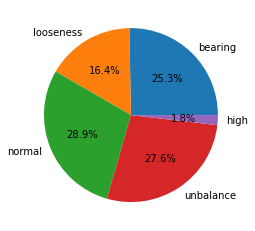

In [5]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [6]:
import tensorflow as tf

In [7]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487004/487004 [00:27<00:00, 17524.35it/s]


In [8]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184375/184375 [00:10<00:00, 17790.52it/s]


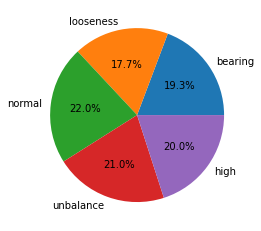

In [9]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [10]:
batch_size = 128
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(batch_size).prefetch(1)

In [ ]:
Dataset.__len__().numpy()

19007

In [11]:

Valid_Dataset = Dataset.take(15 * batch_size) 
Train_Dataset = Dataset.skip(15 * batch_size)
Train_Dataset = Dataset.take(135 * batch_size)

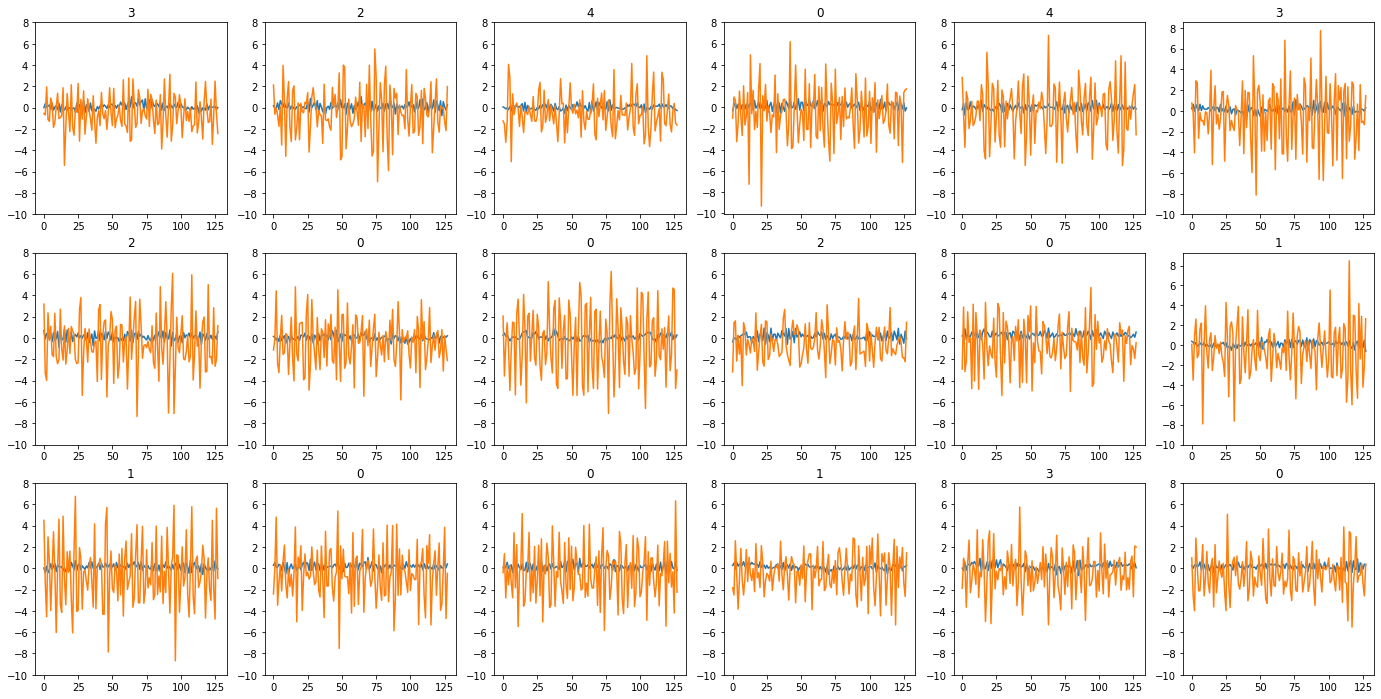

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

In [ ]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

In [ ]:
import  pywt
from scipy import fftpack
import keras

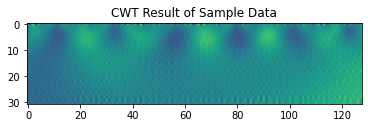

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

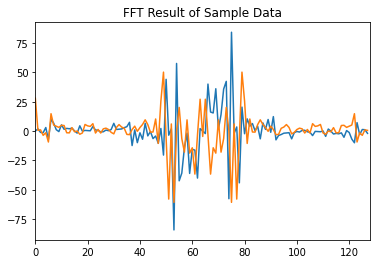

In [ ]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

In [ ]:
'''
class DynFeatures_RealFFT(keras.layers.Layer):
  def __init__(self):#
    super(DynFeatures_RealFFT, self).__init__()
  def call(self, inputs):#이 층이 호출되었을 때 return해주는 값 설중
    fft = tf.signal.fft(tf.cast(inputs, tf.complex64))#cast는 연산효율이 안좋아서 웬만하면 쓰지않음
    return tf.math.real(fft)
class DynFeatures_ImagFFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_ImagFFT, self).__init__()
  def call(self, inputs):
    return tf.math.imag(tf.signal.fft(tf.cast(inputs, tf.complex64)))

class Statiscal_Analysis(keras.layers.Layer):
  #mean,min, max, RMS
  def __init__(self, length_of_signal = 128):
    super(Statiscal_Analysis, self).__init__()
    self.length_of_signal = length_of_signal
  def call(self, inputs):
    mean = tf.reduce_mean(inputs, axis = 1)
    max = tf.reduce_max(inputs, axis = 1)
    min = tf.reduce_min(inputs, axis = 1)
    RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
    var = tf.math.reduce_variance(inputs, axis = 1)
    return tf.stack([mean,max,min,RMS,var], axis = 1)
  #Build는 학습할 수 있는 파라미터가 존재할 때

'''
class DynFeatures_RealFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_RealFFT, self).__init__()

    def call(self, inputs):
      fft = tf.signal.fft(tf.cast(inputs, tf.complex64))
      return tf.math.real(fft)

class DynFeatures_ImagFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_ImagFFT, self).__init__()

    def call(self, inputs):
      return tf.math.imag( tf.signal.fft(tf.cast(inputs, tf.complex64)))

class Statiscal_Analysis(keras.layers.Layer):
    # mean, min, max, RMS
    # Var, Skewness, Kurtosis
    # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
      super(Statiscal_Analysis, self).__init__()
      self.length_of_signal = length_of_signal
    def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.stack([mean,max,min,RMS,var],axis = 1)


In [ ]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [13]:
# Reference - https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer/notebook

%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# tf.experimental.numpy.kron does not work on windows, use numpy.kron directly through a tf.numpy_function() wrapper
@tf.function
def kron(a, b):
    return tf.numpy_function(np.kron, [a, b], tf.complex64)

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt

Overwriting tf_cwt.py


In [ ]:
from tf_cwt import Wavelet1D

CLSTM without cwt 

In [ ]:
def Convolutional_LSTM(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  #c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  #c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  #c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  #c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM = Convolutional_LSTM()


In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]
CLSTM.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',precision, recall, f1score])

hist1 = CLSTM.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/10
17280/17280 [==============================] - 173s 10ms/step - loss: 0.0556 - accuracy: 0.9859 - precision: 0.7803 - recall: 0.9954 - f1score: 0.8740 - val_loss: 0.0078 - val_accuracy: 0.9979 - val_precision: 0.7796 - val_recall: 1.0000 - val_f1score: 0.8756
Epoch 2/10
17280/17280 [==============================] - 169s 10ms/step - loss: 0.0107 - accuracy: 0.9978 - precision: 0.7800 - recall: 0.9998 - f1score: 0.8758 - val_loss: 0.0042 - val_accuracy: 0.9987 - val_precision: 0.7813 - val_recall: 1.0000 - val_f1score: 0.8767
Epoch 3/10
17280/17280 [==============================] - 169s 10ms/step - loss: 0.0076 - accuracy: 0.9985 - precision: 0.7799 - recall: 0.9999 - f1score: 0.8757 - val_loss: 0.0022 - val_accuracy: 0.9994 - val_precision: 0.7794 - val_recall: 1.0000 - val_f1score: 0.8755
Epoch 4/10
17280/17280 [==============================] - 169s 10ms/step - loss: 0.0080 - accuracy: 0.9988 - precision: 0.7799 - recall: 0.9999 - f1score: 0.8757 - val_loss: 0.0028 - val_

In [15]:
import keras
class DynFeatures_RealFFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_RealFFT, self).__init__()
  def call(self, inputs):
    fft = tf.signal.fft(tf.cast(inputs, tf.complex64)) #이거 해줘야  에러가 안남 하지만 cast는 웬만해서는 안쓰느게 좋은
    return tf.math.real(fft)
class DynFeatures_ImagFFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_ImagFFT, self).__init__()
  def call(self, inputs):
    fft = tf.signal.fft(tf.cast(inputs, tf.complex64)) #이거 해줘야  에러가 안남 하지만 cast는 웬만해서는 안쓰느게 좋은
    return tf.math.imag(fft)
    '''
class DynFeatures_STFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_STFT, self).__init__()
  def call(self, inputs):
    stft_frame = tf.signal.stft(inputs, frame_length = 32, frame_step = 8)
    stft = tf.expand_dims(stft_frame[0],-1)
    
    
    return abs(stft)'''

class DynFeatures_STFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_STFT, self).__init__()
    
  def call(self, inputs):
    stft1 = tf.expand_dims(tf.signal.stft(inputs[:, :, 0], frame_length = 32, frame_step = 8), axis=-1)
    stft2 = tf.expand_dims(tf.signal.stft(inputs[:, :, 1], frame_length = 32, frame_step = 8), axis=-1)
    stft = tf.concat([stft1, stft2], axis = -1)
    stft = tf.abs(stft)
    return stft

class Statiscal_Analysis(keras.layers.Layer):
  def __init__(self, length_of_signal = 128):
    super(Statiscal_Analysis, self).__init__()
    self.length_of_signal = length_of_signal
  def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      max = tf.reduce_max(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      min = tf.reduce_min(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))# (None,128,2) ->(None,1,2)
      var = tf.math.reduce_variance(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      return tf.stack([mean,max,min,RMS,var],axis = 1)#(None,5,2)

CLSTM without cwt(+FFT stat)

In [ ]:
def Convolutional_LSTM2(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  #c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  #c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  #c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  #c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  stft = DynFeatures_STFT()(input)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs,stft])
  i_s = Statiscal_Analysis(length_of_signal=128)(i)
  r_s = Statiscal_Analysis(length_of_signal=128)(r)
  fft_stat = keras.layers.Concatenate()([i_s, r_s])
  fft_stat = keras.layers.Flatten()(fft_stat)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, fft_stat])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM2 = Convolutional_LSTM2()

In [ ]:
CLSTM2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',precision, recall, f1score])

hist2 = CLSTM2.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/10
17280/17280 [==============================] - 171s 10ms/step - loss: 0.0695 - accuracy: 0.9832 - precision: 0.7801 - recall: 0.9943 - f1score: 0.8734 - val_loss: 0.0314 - val_accuracy: 0.9918 - val_precision: 0.7802 - val_recall: 0.9998 - val_f1score: 0.8760
Epoch 2/10
17280/17280 [==============================] - 168s 10ms/step - loss: 0.0124 - accuracy: 0.9976 - precision: 0.7799 - recall: 0.9998 - f1score: 0.8757 - val_loss: 0.0028 - val_accuracy: 0.9993 - val_precision: 0.7799 - val_recall: 0.9999 - val_f1score: 0.8758
Epoch 3/10
17280/17280 [==============================] - 168s 10ms/step - loss: 0.0090 - accuracy: 0.9984 - precision: 0.7799 - recall: 0.9998 - f1score: 0.8757 - val_loss: 0.0024 - val_accuracy: 0.9993 - val_precision: 0.7809 - val_recall: 1.0000 - val_f1score: 0.8765
Epoch 4/10
17280/17280 [==============================] - 168s 10ms/step - loss: 0.0079 - accuracy: 0.9987 - precision: 0.7799 - recall: 0.9998 - f1score: 0.8757 - val_loss: 0.0016 - val_

In [35]:

class Statiscal_Analysis(keras.layers.Layer):
  def __init__(self, length_of_signal = 128):
    super(Statiscal_Analysis, self).__init__()
    self.length_of_signal = length_of_signal
  def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      max = tf.reduce_max(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      min = tf.reduce_min(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))# (None,128,2) ->(None,1,2)
      var = tf.math.reduce_variance(inputs,axis = 1)# (None,128,2) ->(None,1,2)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      return tf.stack([mean,max,min,RMS,var],axis = 1)#(None,5,2)

CLSTM without cwt(+FFT stat full)

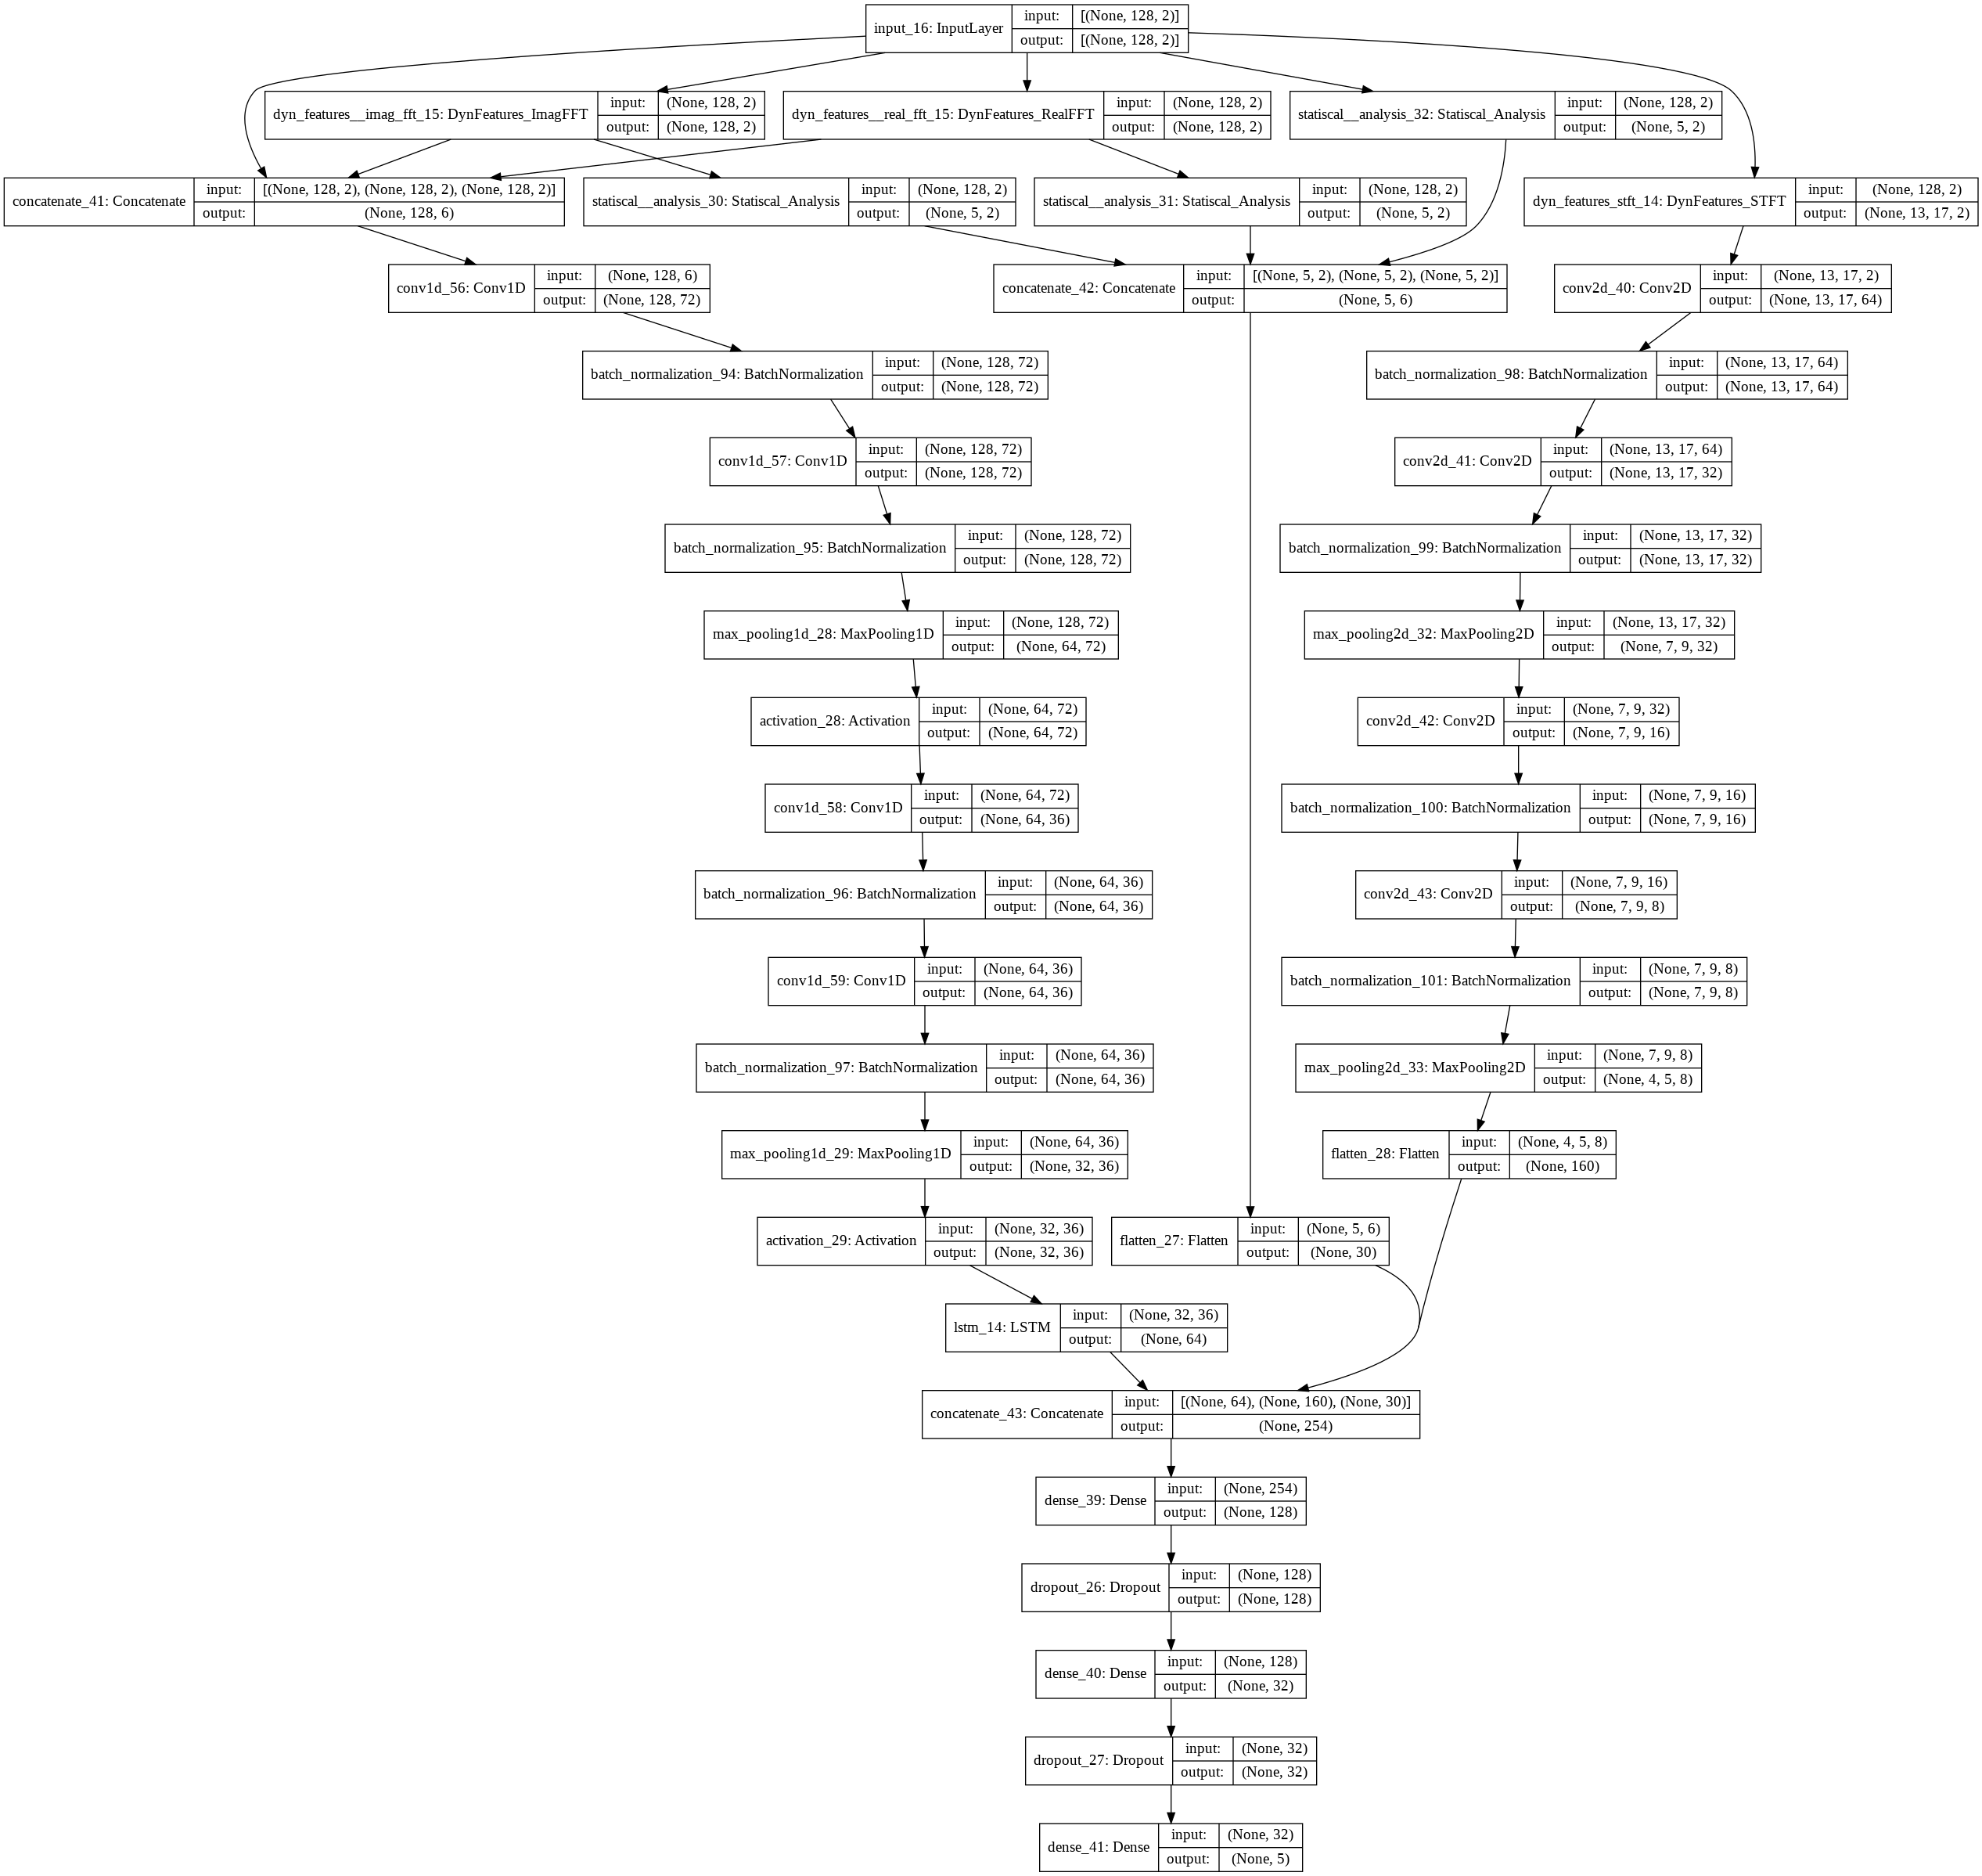

In [40]:
def Convolutional_LSTM3(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  #c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  #c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  #c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  #c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  stft = DynFeatures_STFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])

  #stat
  i_s = Statiscal_Analysis(length_of_signal=128)(i)
  r_s = Statiscal_Analysis(length_of_signal=128)(r)
  stat = Statiscal_Analysis(length_of_signal=128)(inputs)
  fft_stat = keras.layers.Concatenate()([i_s, r_s, stat])
  fft_stat = keras.layers.Flatten()(fft_stat)
  
  x1 = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x1 = keras.layers.BatchNormalization()(x1)
  x1 = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x1)
  x1 = keras.layers.BatchNormalization()(x1)
  x1 = keras.layers.MaxPool1D(pool_size = 2)(x1)
  x1 = keras.layers.Activation('elu')(x1)
  x1 = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x1)
  x1 = keras.layers.BatchNormalization()(x1)
  x1 = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x1)
  x1 = keras.layers.BatchNormalization()(x1)
  x1 = keras.layers.MaxPool1D(pool_size = 2)(x1)
  x1 = keras.layers.Activation('elu')(x1)
  x1 = keras.layers.LSTM(64)(x1)
  

  x2 = keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(stft)
  x2 = keras.layers.BatchNormalization()(x2)
  #x2 = keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same')(x2)
  x2 = keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(x2)
  x2 = keras.layers.BatchNormalization()(x2)
  x2 = keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same')(x2)
  x2 = keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(x2)
  x2 = keras.layers.BatchNormalization()(x2)
  #x2 = keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same')(x2)
  x2 = keras.layers.Conv2D(8, kernel_size = (3,3), padding = 'same', activation = 'relu')(x2)
  x2 = keras.layers.BatchNormalization()(x2)
  x2 = keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same')(x2)
  x2 = keras.layers.Flatten()(x2)

  x = keras.layers.Concatenate()([x1, x2,fft_stat])
  x = keras.layers.Dense(units = 128, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM3 = Convolutional_LSTM3()
tf.keras.utils.plot_model(CLSTM3, show_shapes=True)

In [41]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]
CLSTM3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist3 = CLSTM3.fit(Train_Dataset, epochs = 30, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/30
17280/17280 [==============================] - 218s 12ms/step - loss: 0.0476 - accuracy: 0.9875 - val_loss: 0.0129 - val_accuracy: 0.9960
Epoch 2/30
17280/17280 [==============================] - 214s 12ms/step - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.0127 - val_accuracy: 0.9970
Epoch 3/30
17280/17280 [==============================] - 213s 12ms/step - loss: 0.0100 - accuracy: 0.9983 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 4/30
17280/17280 [==============================] - 213s 12ms/step - loss: 0.0085 - accuracy: 0.9985 - val_loss: 0.0072 - val_accuracy: 0.9997
Epoch 5/30
17280/17280 [==============================] - 213s 12ms/step - loss: 0.0087 - accuracy: 0.9987 - val_loss: 0.0053 - val_accuracy: 0.9984
Epoch 6/30
17280/17280 [==============================] - 213s 12ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 7/30
17280/17280 [==============================] - 213s 12ms/step - loss: 0.0076 - accuracy: 0.9989

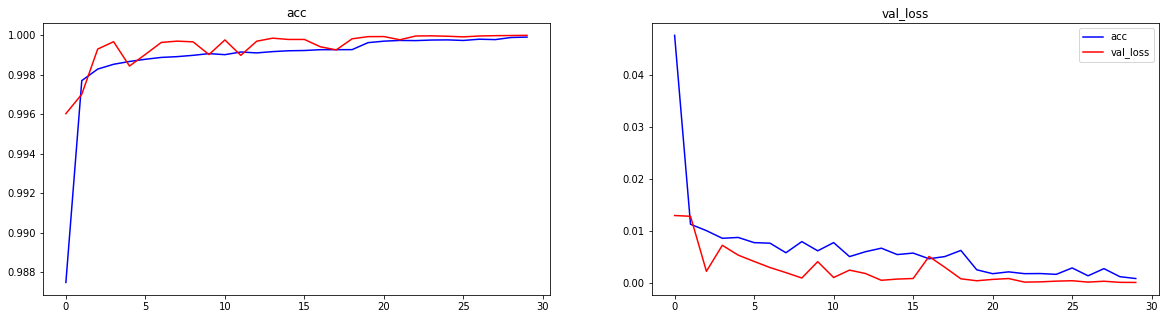

In [51]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hist3.history['accuracy'], c = 'b')
ax1.plot(hist3.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(hist3.history['loss'], c = 'b')
ax2.plot(hist3.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7c3a9d950>]],
      dtype=object)

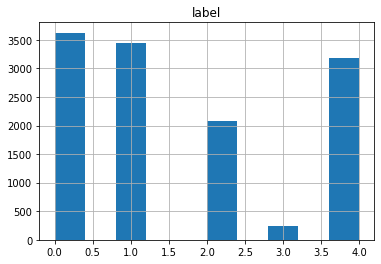

In [50]:
Test_Dataset = Test_Dataset.batch(128)
pred=CLSTM3.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CLSTM3_김건_2.csv', index = False)
sub.hist()

NotImplementedError: ignored

In [ ]:
class Statiscal_Analysis_1(keras.layers.Layer):
    # mean, min, max, RMS
    # Var, Skewness, Kurtosis
    # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
      super(Statiscal_Analysis_1, self).__init__()
      self.length_of_signal = length_of_signal
    def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.stack([mean,max,min,RMS,var],axis = 1)

CLSTM without cwt (FFT full stat, input 5 stat )

In [ ]:
def Convolutional_LSTM4(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  #c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  #c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  #c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  #c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])

  s = Statiscal_Analysis_1(length_of_signal=128)(inputs) #5개
  i_s = Statiscal_Analysis(length_of_signal=128)(i) #10개
  r_s = Statiscal_Analysis(length_of_signal=128)(r) #10개
  fft_stat = keras.layers.Concatenate()([s,r_s,i_s])
  
  fft_stat = keras.layers.Flatten()(fft_stat)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, fft_stat])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM4 = Convolutional_LSTM4()

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]
CLSTM4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',precision, recall, f1score])

hist4 = CLSTM4.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/10
17280/17280 [==============================] - 173s 10ms/step - loss: 0.0747 - accuracy: 0.9807 - precision: 0.7803 - recall: 0.9929 - f1score: 0.8728 - val_loss: 0.0074 - val_accuracy: 0.9982 - val_precision: 0.7809 - val_recall: 1.0000 - val_f1score: 0.8765
Epoch 2/10
17280/17280 [==============================] - 169s 10ms/step - loss: 0.0131 - accuracy: 0.9974 - precision: 0.7801 - recall: 0.9997 - f1score: 0.8758 - val_loss: 0.0075 - val_accuracy: 0.9982 - val_precision: 0.7801 - val_recall: 0.9999 - val_f1score: 0.8759
Epoch 3/10
17280/17280 [==============================] - 169s 10ms/step - loss: 0.0108 - accuracy: 0.9981 - precision: 0.7800 - recall: 0.9998 - f1score: 0.8758 - val_loss: 0.0056 - val_accuracy: 0.9986 - val_precision: 0.7789 - val_recall: 1.0000 - val_f1score: 0.8752
Epoch 4/10
17280/17280 [==============================] - 170s 10ms/step - loss: 0.0092 - accuracy: 0.9985 - precision: 0.7800 - recall: 0.9998 - f1score: 0.8758 - val_loss: 0.0056 - val_

----------------

In [ ]:
#ft 만들기
def tf_fft(series_t):
  tf_fft = tf.signal.rfft(series_t)
  tf_fft = tf.cast(tf_fft, tf.float64)
  
  return tf_fft

def tf_reshape_fft(series, label):
  series_t = tf.transpose(series)
  fft1 = tf.expand_dims(tf_fft(series_t[0]), axis=-1)
  fft2 = tf.expand_dims(tf_fft(series_t[1]), axis=-1)
  fft = tf.concat([fft1, fft2], axis = -1)
  return fft, label

In [ ]:
#stft 만들기
def tf_stft(series_t):
  spectro = tf.signal.stft(series_t, frame_length = 32, frame_step = 24)
  
  return tf.abs(spectro)

def tf_reshape_stft(series, label):
  series_t = tf.transpose(series)
  spectros1 = tf.expand_dims(tf_stft(series_t[0]), axis=-1)
  spectros2 = tf.expand_dims(tf_stft(series_t[1]), axis=-1)
  spectros = tf.concat([spectros1, spectros2], axis = -1)
  spectros = tf.abs(spectros)
  return spectros, label

In [ ]:
#Train_Dataset_stft = Train_Dataset.unbatch().map(tf_reshape_stft).batch(128)
#Valid_Dataset_stft = Valid_Dataset.unbatch().map(tf_reshape_stft).batch(128)
#Test_Dataset_stft = Test_Dataset.unbatch().map(tf_reshape_stft).batch(128)

In [ ]:
Train_Dataset_fft = Train_Dataset.unbatch().map(tf_reshape_fft).batch(128)
Valid_Dataset_fft = Valid_Dataset.unbatch().map(tf_reshape_fft).batch(128)
#Test_Dataset_fft = Test_Dataset.unbatch().map(tf_reshape_stft).batch(128)

In [ ]:
Train_Dataset_raw = Train_Dataset.unbatch().batch(128)
Valid_Dataset_raw = Valid_Dataset.unbatch().batch(128)

In [ ]:
Train_Dataset_raw

<BatchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
Train_Dataset_fft

<BatchDataset shapes: ((None, 65, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
#Train_Dataset_stft

In [ ]:
'''
Train_Dataset_fusion_x = tf.data.Dataset.zip((Train_Dataset_raw.unbatch(),Train_Dataset_stft.unbatch(), Train_Dataset_fft.unbatch())).map(lambda x1, x2, x3: {'x1': x1[0], 'x2': x2[0], 'x3' : x3[0]})
Train_Dataset_fusion_y = Train_Dataset_stft.unbatch().map(lambda x, y: y) 
Train_Dataset_fusion = tf.data.Dataset.zip((Train_Dataset_fusion_x, Train_Dataset_fusion_y)).batch(128)
Valid_Dataset_fusion_x = tf.data.Dataset.zip((Valid_Dataset_raw.unbatch(),Valid_Dataset_stft.unbatch(), Valid_Dataset_fft.unbatch())).map(lambda x1, x2, x3: {'x1': x1[0], 'x2': x2[0], 'x3' : x3[0]})
Valid_Dataset_fusion_y = Valid_Dataset_stft.unbatch().map(lambda x, y: y)
Valid_Dataset_fusion = tf.data.Dataset.zip((Valid_Dataset_fusion_x, Valid_Dataset_fusion_y)).batch(128)
'''

In [ ]:
import keras

In [ ]:

Train_Dataset_fusion_x = tf.data.Dataset.zip((Train_Dataset_raw.unbatch(), Train_Dataset_fft.unbatch())).map(lambda x1, x2: {'x1': x1[0], 'x2': x2[0]})
Train_Dataset_fusion_y = Train_Dataset_fft.unbatch().map(lambda x, y: y) 
Train_Dataset_fusion = tf.data.Dataset.zip((Train_Dataset_fusion_x, Train_Dataset_fusion_y)).batch(128)
Valid_Dataset_fusion_x = tf.data.Dataset.zip((Valid_Dataset_raw.unbatch(), Valid_Dataset_fft.unbatch())).map(lambda x1, x2: {'x1': x1[0], 'x2': x2[0]})
Valid_Dataset_fusion_y = Valid_Dataset_fft.unbatch().map(lambda x, y: y)
Valid_Dataset_fusion = tf.data.Dataset.zip((Valid_Dataset_fusion_x, Valid_Dataset_fusion_y)).batch(128)


In [ ]:
def build_model2():
    #(128, 2), x2: (None, 13, 17, 2), x3: (None, 65, 2)}, (None,)), types: ({x1: tf.float64, x2: tf.float64, x3: tf.float64}, tf.float64)>
    input1 = keras.layers.Input(shape=(128, 2), dtype=tf.float64, name='x1')
    #input2 = keras.layers.Input(shape=(13, 17, 2), dtype=tf.float64, name='x2')
    input2 = keras.layers.Input(shape=(65, 2), dtype=tf.float64, name='x2')
    #input2_ = keras.layers.Flatten()(input2)

    y1 = keras.layers.Conv1D(64,kernel_size=3,activation="relu", padding="same" , input_shape = (128, 2))(input1)
    y1 = keras.layers.MaxPooling1D(1)(y1)
    y1 = keras.layers.Conv1D(32,kernel_size=3,activation="relu",padding="same" , input_shape = (128, 2))(y1)
    y1 = keras.layers.MaxPooling1D(1)(y1)
    #y1 = keras.layers.Flatten()(y1)
    
    #y1 = keras.layers.Flatten()(y1)
    '''
    y2 = keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2))(input2)
    y2 = keras.layers.MaxPool2D(pool_size = (2,2))(y2)
    y2 = keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2))(y2)
    y2 = keras.layers.MaxPool2D(pool_size = (2,2))(y2)
    y2 = keras.layers.Flatten()(y2)'''
    
    #(3,4)

    y2 = keras.layers.Conv1D(64, kernel_size=3,activation="relu", padding="same" , input_shape = (65, 2))(input2)
    y2 = keras.layers.MaxPooling1D(1)(y2)
    y2 = keras.layers.Conv1D(32, kernel_size=3,activation="relu",padding="same" , input_shape = (65, 2))(y2)
    y2 = keras.layers.MaxPooling1D(1)(y2)
    #y2 = keras.layers.Flatten()(y2)
    


    
    y4 = keras.layers.Concatenate(axis=1)([y1, y2])
    
    y4 = keras.layers.LSTM(40,return_sequences=False, dropout=0.3)(y4)    
    y4 = keras.layers.Flatten()(y4)
    y4 = keras.layers.Dense(64, activation = 'relu')(y4)
    y4 = keras.layers.Dropout(0.3)(y4)
    y4 = keras.layers.Dense(32, activation = 'relu')(y4)
    y4 = keras.layers.Dropout(0.3)(y4)
    y = keras.layers.Dense(5, activation = 'softmax')(y4)
    return keras.models.Model(inputs=[input1, input2], outputs=y)

In [ ]:
'''def build_model1():
    #(128, 2), x2: (None, 7, 17, 2), x3: (None, 65, 2)}, (None,)), types: ({x1: tf.float64, x2: tf.float64, x3: tf.float64}, tf.float64)>
    input1 = keras.layers.Input(shape=(128, 2), dtype=tf.float64, name='x1')
    input2 = keras.layers.Input(shape=(13, 17, 2), dtype=tf.float64, name='x2')
    input3 = keras.layers.Input(shape=(65, 2), dtype=tf.float64, name='x3')
    #input2_ = keras.layers.Flatten()(input2)

    y1 = keras.layers.Conv1D(32,kernel_size=3,activation="relu", padding="same" , input_shape = (128, 2))(input1)
    y1 = keras.layers.MaxPooling1D(1)(y1)
    y1 = keras.layers.Conv1D(64,kernel_size=3,activation="relu",padding="same" , input_shape = (128, 2))(y1)
    y1 = keras.layers.MaxPooling1D(1)(y1)
    #y1 = keras.layers.Flatten()(y1)
    
    #y1 = keras.layers.Flatten()(y1)
    
    y2 = keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (7, 17, 2))(input2)
    y2 = keras.layers.MaxPool2D(pool_size = (2,2))(y2)
    y2 = keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (6, 8, 32))(y2)
    y2 = keras.layers.MaxPool2D(pool_size = (2,2))(y2)
    y2 = tf.keras.layers.Reshape((-1,64), input_shape = (3, 4, 64))(y2)
    #y2 = keras.layers.Flatten()(y2)
    
    y3 = keras.layers.Conv1D(32, kernel_size=3,activation="relu", padding="same" , input_shape = (65, 2))(input3)
    y3 = keras.layers.MaxPooling1D(1)(y3)
    y3 = keras.layers.Conv1D(64, kernel_size=3,activation="relu",padding="same" , input_shape = (65, 2))(y3)
    y3 = keras.layers.MaxPooling1D(1)(y3)
    
    #y2 = keras.layers.Flatten()(y2)
    


    
    y4 = keras.layers.Concatenate(axis=1)([y1, y2, y3])
    
    y4 = keras.layers.LSTM(50,return_sequences=False)(y4)    
    y4 = keras.layers.Dropout(0.3)(y4)
    
    y4 = keras.layers.Dense(16, activation = 'relu')(y4)
    y4 = keras.layers.Dropout(0.2)(y4)
    y = keras.layers.Dense(5, activation = 'softmax')(y4)

    return keras.models.Model(inputs=[input1, input2, input3], outputs=y4)
    '''

'def build_model1():\n    #(128, 2), x2: (None, 7, 17, 2), x3: (None, 65, 2)}, (None,)), types: ({x1: tf.float64, x2: tf.float64, x3: tf.float64}, tf.float64)>\n    input1 = keras.layers.Input(shape=(128, 2), dtype=tf.float64, name=\'x1\')\n    input2 = keras.layers.Input(shape=(13, 17, 2), dtype=tf.float64, name=\'x2\')\n    input3 = keras.layers.Input(shape=(65, 2), dtype=tf.float64, name=\'x3\')\n    #input2_ = keras.layers.Flatten()(input2)\n\n    y1 = keras.layers.Conv1D(32,kernel_size=3,activation="relu", padding="same" , input_shape = (128, 2))(input1)\n    y1 = keras.layers.MaxPooling1D(1)(y1)\n    y1 = keras.layers.Conv1D(64,kernel_size=3,activation="relu",padding="same" , input_shape = (128, 2))(y1)\n    y1 = keras.layers.MaxPooling1D(1)(y1)\n    #y1 = keras.layers.Flatten()(y1)\n    \n    #y1 = keras.layers.Flatten()(y1)\n    \n    y2 = keras.layers.Conv2D(32, kernel_size = (3,3), padding = \'same\', activation = \'relu\', input_shape = (7, 17, 2))(input2)\n    y2 = keras.la

In [ ]:
CUSTOM_MODEL = build_model2()
CUSTOM_MODEL.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
x2 (InputLayer)                 [(None, 65, 2)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 64)      448         x1[0][0]                         
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 65, 64)       448         x2[0][0]                         
______________________________________________________________________________________________

In [ ]:
Valid_Dataset_fusion 

<BatchDataset shapes: ({x1: (None, 128, 2), x2: (None, 65, 2)}, (None,)), types: ({x1: tf.float64, x2: tf.float64}, tf.float64)>

In [ ]:
Train_Dataset_fusion

<BatchDataset shapes: ({x1: (None, 128, 2), x2: (None, 65, 2)}, (None,)), types: ({x1: tf.float64, x2: tf.float64}, tf.float64)>

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

CUSTOM_MODEL.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?

In [ ]:
history = CUSTOM_MODEL.fit(Train_Dataset_fusion, epochs = 2, shuffle = True, validation_data = Valid_Dataset_fusion)

Epoch 1/2
  16007/Unknown - 292s 16ms/step - loss: 1.6072 - accuracy: 0.2181

In [ ]:
tf.transpose(x,[1,0,2])